## Factors that affect consumer ratings

This notebook will focus on data exploration, looking for correlations within the data. It's mostly expected that customer service and the quality of food affect ratings of restaurants. However,these factors are included in these datasets. But some of the features of a restaurant still have some influence on the ratings. For a context-based recommender system, finding the relevant features is important for improving the rating prediction.

### Extract, Transform & Load.

We are extracting data from hdfs and loading, transform as a pandas dataframe before loading into pyspark

In [62]:
#Set up the spark environment
#i. import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [63]:
#ii. Build a SparkConf object that contains info about the application
conf = SparkConf().setAppName('appName').setMaster('local')

#iii. Use the SparkConf object to create a Spark Context
sc= SparkContext.getOrCreate(conf=conf)

#iv. Use Spart Context to create a new Session
spark = SparkSession(sc)

In [64]:
#Step 2: Load text file from hadoop
chefmozaccepts = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/chefmozaccepts.csv')
chefmozcuisine = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/chefmozcuisine.csv')
chefmozhours4 = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/chefmozhours4.csv')
chefmozparking = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/chefmozparking.csv')
geoplaces2 = spark.read.format("csv").option("header", "true").option('encoding', 'latin1').load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/geoplaces2.csv')
usercuisine = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/usercuisine.csv')
userpayment = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/userpayment.csv')
userprofile = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/userprofile.csv')
rating_final = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/restaurant-data-with-consumer-ratings/rating_final.csv')

# data_elements= rdd.collect()
# # print(data_elements)

In [65]:
#Import necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

pd.set_option('mode.chained_assignment', None)

# Note that there are no NANs in these data; '?' is
# used when there is missing information

accepts = chefmozaccepts.select("*").toPandas()
# print(accepts)
print('accepts shape: ', accepts.shape)

cuisine = chefmozcuisine.select("*").toPandas()
# print(cuisine)
print('cuisine shape: ', cuisine.shape)

hours = chefmozhours4.select("*").toPandas()
# print(hours)
print('hours shape: ', hours.shape)

parking = chefmozparking.select("*").toPandas()
# print(parking)
print('parking shape: ', parking.shape)

geo = geoplaces2.select("*").toPandas()
# print(geo)
print('geo shape: ', geo.shape)

usercuisine = usercuisine.select("*").toPandas()
# print(usercuisine)
print('usercuisine shape: ', usercuisine.shape)

payment = userpayment.select("*").toPandas()
# print(payment)
print('payment shape: ', payment.shape)

profile = userprofile.select("*").toPandas()
# print(profile)
print('profile shape: ', profile.shape)

rating = rating_final.select("*").toPandas()
# print(rating)
print('rating shape: ', rating.shape)

accepts shape:  (1314, 2)
cuisine shape:  (916, 2)
hours shape:  (2339, 3)
parking shape:  (702, 2)
geo shape:  (130, 21)
usercuisine shape:  (330, 2)
payment shape:  (177, 2)
profile shape:  (138, 19)
rating shape:  (1161, 5)


# Data Preprocessing

Replace '?', 'none', 'None' and 'No' with nan

In [66]:
accepts.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
print(accepts.head())

cuisine.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
# cuisine

hours.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
# chefmozhours4

'''None for the parking lot simply means the restaurant does not have a parking lot and is therefore not missing data'''
parking.replace(['?','no'], np.NaN, inplace=True)
# chefmozparking
geo.replace(['?','no'], np.NaN, inplace=True)
geo

usercuisine.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
# usercuisine

payment.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
# userpayment

profile.replace(['?', 'no'], np.NaN, inplace=True)
# profile

rating.replace(['?', 'none', 'None' 'no'], np.NaN, inplace=True)
# rating

  placeID             Rpayment
0  135110                 cash
1  135110                 VISA
2  135110  MasterCard-Eurocard
3  135110     American_Express
4  135110     bank_debit_cards


In [67]:
# accepts.isnull().sum(axis=0) #No null values
# cuisine.isnull().sum(axis=0) #No null values
# hours.isnull().sum(axis=0) #No null values
# parking.isnull().sum(axis=0) #No null values
# geo.isnull().sum(axis=0) #has null values
# rating.isnull().sum(axis=0) #No null values
# usercuisine.isnull().sum(axis=0) #No null values
# payment.isnull().sum(axis=0) #No null values
# profile.isnull().sum(axis=0) #has null values

In [68]:
# Drop (‘fax’,’zip’,’url’) columns from ‘geoplaces2.csv’
geo.dropna(thresh=100, axis=1, inplace=True)
# Use Forward fill to fill the missing values in the remaining geoplaces dataset
geo.fillna(method='ffill', inplace=True)
geo.isnull().sum(axis=0)

placeID           0
latitude          0
longitude         0
the_geom_meter    0
name              0
address           0
city              0
state             0
country           0
alcohol           0
smoking_area      0
dress_code        0
accessibility     0
price             0
Rambience         0
franchise         0
area              0
other_services    0
dtype: int64

In [69]:
 # (No explicit reason for choosing forward and back fills. 
   # These are just random choices give that there seems to be no other better way to fill the missing values)
profile.fillna(method='bfill', inplace=True)
profile.isnull().sum(axis=0)

userID              0
latitude            0
longitude           0
smoker              0
drink_level         0
dress_preference    0
ambience            0
transport           0
marital_status      0
hijos               0
birth_year          0
interest            0
personality         0
religion            0
activity            0
color               0
weight              0
budget              0
height              0
dtype: int64

In [70]:
# Check for duplicates in all the files
print('no. of duplicates in chefmozaccepts', accepts.duplicated().sum(axis=0))
print('no. of duplicates in chefmozcuisine', cuisine.duplicated().sum(axis=0))
print('no. of duplicates in chefmozhours4', hours.duplicated().sum(axis=0))
print('no. of duplicates in chefmozparking', parking.duplicated().sum(axis=0))
print('no. of duplicates in geoplaces2', geo.duplicated().sum(axis=0))
print('no. of duplicates in rating_final', rating.duplicated().sum(axis=0))
print('no. of duplicates in usercuisine', usercuisine.duplicated().sum(axis=0))
print('no. of duplicates in userpayment', payment.duplicated().sum(axis=0))
print('no. of duplicates in userprofile', profile.duplicated().sum(axis=0))

no. of duplicates in chefmozaccepts 0
no. of duplicates in chefmozcuisine 0
no. of duplicates in chefmozhours4 271
no. of duplicates in chefmozparking 0
no. of duplicates in geoplaces2 0
no. of duplicates in rating_final 0
no. of duplicates in usercuisine 0
no. of duplicates in userpayment 0
no. of duplicates in userprofile 0


The opening hours data has 271 duplicates, we are deleting them as below.

In [71]:
print('shape of chefmozhours4 before removing duplicates', hours.shape)
# check for duplicates on chefmozhours4 dataset using instance method duplicated
print('no. of duplicates', hours.duplicated().sum(axis=0))
# Remove the duplicate using drop_duplicates
hours.drop_duplicates(inplace = True)
print('shape of chefmozhours4 after removing duplicates', hours.shape)

shape of chefmozhours4 before removing duplicates (2339, 3)
no. of duplicates 271
shape of chefmozhours4 after removing duplicates (2068, 3)


In [72]:
print("There are {} unique userID's.".format(len(rating.userID.unique())))
print("There are {} unique placeID's.".format(len(rating.placeID.unique())))
print("There are {} * 3 ratings.".format(len(rating)))

There are 138 unique userID's.
There are 130 unique placeID's.
There are 1161 * 3 ratings.


In [73]:
#Check the description of customer ratings
rating.iloc[:, 2:].describe()

,rating,food_rating,service_rating
count,1161,1161,1161
unique,3,3,3
top,2,2,1
freq,486,516,426


Let's check the total number of restaurants

In [74]:
#Concatenate all place IDs and count the unique ones
res_all = np.concatenate((accepts.placeID, cuisine.placeID, 
                          hours.placeID, parking.placeID, geo.placeID))
res_all = np.sort( np.unique(res_all) ) # All the placeID's

print("There are {} restaurants.".format(len(res_all)))

There are 938 restaurants.


Let's check the number of unique users

In [75]:
user_all = np.concatenate((usercuisine.userID, payment.userID, profile.userID))
user_all = np.sort( np.unique(user_all) ) # All the userID's

print("There are {} users.".format(len(user_all)))

There are 138 users.


There are only 130 out of 938 restaurants with ratings. I will later work on these 130 only because it's not wise to recommend a restaurant without ratings. I will now create three data frames for the three types of rating, each of which will have a shape of (938, 130). A restaurant-user pair without a rating will be recorded as -1 (to be different from 0, the lowest rating).

In [77]:
overall_rating = pd.DataFrame( np.zeros((len(res_all),len(user_all)))-1.0, 
                              columns=user_all, index=res_all )
food_rating = overall_rating.copy()
service_rating = overall_rating.copy() 

for r, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    overall_rating.loc[r,u] = int(o)
    food_rating.loc[r,u] = f
    service_rating.loc[r,u] = s

# This tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
review = pd.DataFrame( np.zeros(overall_rating.shape), columns=user_all, index=res_all)
review[overall_rating >= 0] = 1

I'll be looking at the restaurant features from cuisine, parking and geo. The payment options and business hours should have very little effects on the rating, so I won't look into accepts and hours here.

In [78]:
# use dummy variables for different cuisine categories of the restaurants
res_cuisine = pd.get_dummies(cuisine,columns=['Rcuisine'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple cuisine categories would have multiple columns equal 1
res_cuisine = res_cuisine.groupby('placeID',as_index=False).sum()

# use dummy variables for different cuisine categories of the restaurants
res_parking = pd.get_dummies(parking,columns=['parking_lot'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple parking options would have multiple columns equal 1
res_parking = res_parking.groupby('placeID',as_index=False).sum()

Let's select some columns from geo that might affect the ratings.

In [79]:
geo.columns.values

array(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name',
       'address', 'city', 'state', 'country', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'Rambience', 'franchise',
       'area', 'other_services'], dtype=object)

In [80]:
# These are the ones that I think might be relevant
res_features = geo[['placeID','alcohol','smoking_area','other_services','price','dress_code',
               'accessibility','area']]

df_res = pd.DataFrame({'placeID': res_all})
df_res = pd.merge(left=df_res, right=res_cuisine, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_parking, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_features, how="left", on="placeID")

From now on I will use four (130,138) arrays, R, Y_overall, Y_food and Y_service, for their ratings, where the axis=0 dimension is for the restaurants and the axis=1 dimension is for the consumers. The elements of R are either 0 or 1, showing whether a restaurant-user pair has a rating. The information of the restaurants will be recorded in a (130,n_feature) array, X.

In [81]:
# The placeID's for the 130 restaurants with ratings
res_rated = res_all[np.sum(review,axis=1) > 0] 

# tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
R = review.loc[res_rated].values  # shape = (130,138)

# These also have a shape of (130, 138)
Y_overall = overall_rating.loc[res_rated].values
Y_food  = food_rating.loc[res_rated].values
Y_service = service_rating.loc[res_rated].values

# select the indices of "df_res" where a restaurant has ratings
index = [x in res_rated for x in df_res['placeID'].values]

# restaurant features for the 130 restaurants with ratings
X = df_res.loc[index, :].reset_index(drop=True)

X.isnull().sum() # all the NANs are from cuisine

placeID                           0
Rcuisine_Afghan                  35
Rcuisine_African                 35
Rcuisine_American                35
Rcuisine_Armenian                35
Rcuisine_Asian                   35
Rcuisine_Bagels                  35
Rcuisine_Bakery                  35
Rcuisine_Bar                     35
Rcuisine_Bar_Pub_Brewery         35
Rcuisine_Barbecue                35
Rcuisine_Brazilian               35
Rcuisine_Breakfast-Brunch        35
Rcuisine_Burgers                 35
Rcuisine_Cafe-Coffee_Shop        35
Rcuisine_Cafeteria               35
Rcuisine_California              35
Rcuisine_Caribbean               35
Rcuisine_Chinese                 35
Rcuisine_Contemporary            35
Rcuisine_Continental-European    35
Rcuisine_Deli-Sandwiches         35
Rcuisine_Dessert-Ice_Cream       35
Rcuisine_Diner                   35
Rcuisine_Dutch-Belgian           35
Rcuisine_Eastern_European        35
Rcuisine_Ethiopian               35
Rcuisine_Family             

In [82]:
# fill all NANs with 0
X = X.fillna(0) 

# drop a feature if the entire column are 0
features_to_drop = X.columns.values[np.sum(X,axis=0) == 0] 
X = X.drop(features_to_drop, axis=1)

# drop placeID
X = X.drop(['placeID'], axis=1)

# There are the restaurant features we'll explore
X.columns.values 

array(['Rcuisine_American', 'Rcuisine_Armenian', 'Rcuisine_Bakery',
       'Rcuisine_Bar', 'Rcuisine_Bar_Pub_Brewery',
       'Rcuisine_Breakfast-Brunch', 'Rcuisine_Burgers',
       'Rcuisine_Cafe-Coffee_Shop', 'Rcuisine_Cafeteria',
       'Rcuisine_Chinese', 'Rcuisine_Contemporary', 'Rcuisine_Family',
       'Rcuisine_Fast_Food', 'Rcuisine_Game', 'Rcuisine_International',
       'Rcuisine_Italian', 'Rcuisine_Japanese', 'Rcuisine_Mediterranean',
       'Rcuisine_Mexican', 'Rcuisine_Pizzeria', 'Rcuisine_Regional',
       'Rcuisine_Seafood', 'Rcuisine_Vietnamese', 'parking_lot_none',
       'parking_lot_public', 'parking_lot_valet parking',
       'parking_lot_yes', 'alcohol', 'smoking_area', 'other_services',
       'price', 'dress_code', 'accessibility', 'area'], dtype=object)

Now let's select some of the user features that are related to the restaurant features

In [83]:
profile.columns.values

array(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status',
       'hijos', 'birth_year', 'interest', 'personality', 'religion',
       'activity', 'color', 'weight', 'budget', 'height'], dtype=object)

smoker, drink_level, transport, budget and dress_preference are related to smoking_area, alcohol, parking options (parking_lot_none, parking_lot_public, parking_lot_valet parking and parking_lot_yes), price, and dress_code

In [84]:
user_info = profile[['smoker','drink_level','transport','budget','dress_preference']] 

print(user_info.smoker.value_counts())
print('\n')
print(user_info.drink_level.value_counts())
print('\n')
print(user_info.transport.value_counts())
print('\n')
print(user_info.budget.value_counts())
print('\n')
print(user_info.dress_preference.value_counts())

false    111
true      27
Name: smoker, dtype: int64


abstemious        51
casual drinker    47
social drinker    40
Name: drink_level, dtype: int64


public       88
car owner    36
on foot      14
Name: transport, dtype: int64


medium    98
low       35
high       5
Name: budget, dtype: int64


no preference    55
formal           42
informal         37
elegant           4
Name: dress_preference, dtype: int64


Before exploring these data, I will combine "public" and "on foot" of **transport** into just one category, "no car", because these two types of people would feel the same about whether there is a parking lot. Similarly, "elegant" and "formal" of **dress_preference** will be merged to just one category, "formal".

In [85]:
user_info.transport = user_info.transport.replace({'public':'no car', 'on foot':'no car'})
user_info.dress_preference = user_info.dress_preference.replace({'elegant':'formal'})

## Exploratory Visualization
In order to see how the restaurant features affect the ratings, I will first get the mean rating for each restaurant. And then for each feature, I will show how the rating changes with different feature values. To do this, I will group the restaurants based on the different feature values and then average the mean ratings mentioned above for 
each group. Notice that what I do is **NOT** averaging all the ratings with the feature equals to a certain value. Instead, it is first getting the mean rating for each restaurant and then grouping. If the former approach were used, the mean rating of a group would be biased towards the restaurants with more ratings. This should be avoided because we want to treat every restaurant equally.

In [110]:
# Calculate the mean rating for each restaurant
def GetMean(Y,R):

    Y = Y*R
    mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1)
    return mean

Y_overall_mean = GetMean(Y_overall,R)
Y_food_mean = GetMean(Y_food,R)
Y_service_mean = GetMean(Y_service,R)

TypeError: can't multiply sequence by non-int of type 'float'

In [91]:
print(type(R))

<class 'numpy.ndarray'>


In [24]:
# This is the function I'll use to plot and print the mean ratings of different 
# groups of restaurants based on different values of a given feature
def plot_mean_rating(df,rotate=False):
    
    n = df.shape[1]
    columns = df.columns.values
    
    if n > 1:
        y_overall = [ Y_overall_mean[df[i] == 1].mean() for i in columns ]
        y_food = [ Y_food_mean[df[i] == 1].mean() for i in columns ]
        y_service = [ Y_service_mean[df[i] == 1].mean() for i in columns ] 
        y = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service},
                         columns=['overall','food','service'],index=columns) 
        ticks = columns
        
    else:
        values = df[columns[0]].unique()
        values = values[values != '?']
        y_overall = [ Y_overall_mean[df[columns[0]] == i].mean() for i in values ]
        y_food = [ Y_food_mean[df[columns[0]] == i].mean() for i in values ]
        y_service = [ Y_service_mean[df[columns[0]] == i].mean() for i in values ] 
        y = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service},
                         columns=['overall','food','service'],index=values) 
        ticks = values
   
    fig = plt.figure()
    plt.plot(range(y.shape[0]),y['overall'],'-o',c='k',label='overall')
    plt.plot(range(y.shape[0]),y['food'],'-o',c='r',label='food')   
    plt.plot(range(y.shape[0]),y['service'],'-o',c='b',label='service')
    plt.xticks(range(y.shape[0]),ticks,fontsize=13)
    if rotate: plt.xticks(rotation=40)
    plt.yticks(fontsize=13) 
    if n == 1: plt.xlabel(columns[0],fontsize=15)
    plt.ylabel('mean rating',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()
    
    print(y)

In [25]:
# This function is similar to the one above, but this time the result is split
# into different groups of users as well
def plot_mean_rating_split(df,userinfo,rotate=False):
    
    n = df.shape[1]
    columns = df.columns.values
    
    cases = userinfo.unique()
    cases = cases[cases != '?']
    
    num = len(cases)
    y = {}
    
    if n > 1:
        
        for i in range(num):
            
            index = (userinfo == cases[i])
            R_case = np.zeros(R.shape)
            R_case[:,index] = R[:,index]

            Y_overall_case = GetMean(Y_overall,R_case)
            Y_food_case = GetMean(Y_food,R_case)
            Y_service_case = GetMean(Y_service,R_case)
        
            isnan = np.isnan(Y_overall_case).reshape(-1)
            y_overall = [Y_overall_case[(df[j] == 1) & (isnan == False)].mean() for j in columns]
            y_food = [Y_food_case[(df[j] == 1) & (isnan == False)].mean() for j in columns]
            y_service = [Y_service_case[(df[j] == 1) & (isnan == False)].mean() for j in columns]
            
            y[cases[i]] = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service}, 
                                   columns=['overall','food','service'],index=columns)
        ticks = columns

     
    else:
        
        for i in range(num):
            
            values = df[columns[0]].unique()
            values = values[values != '?']
            
            index = (userinfo == cases[i])
            R_case = np.zeros(R.shape)
            R_case[:,index] = R[:,index]

            Y_overall_case = GetMean(Y_overall,R_case)
            Y_food_case = GetMean(Y_food,R_case)
            Y_service_case = GetMean(Y_service,R_case)
        
            isnan = np.isnan(Y_overall_case).reshape(-1)
            y_overall = [Y_overall_case[(df[columns[0]] == j) & 
                        (isnan == False)].mean() for j in values]
            y_food = [Y_food_case[(df[columns[0]] == j) & 
                     (isnan == False)].mean() for j in values]
            y_service = [Y_service_case[(df[columns[0]] == j) & 
                        (isnan == False)].mean() for j in values]
                        
            y[cases[i]] = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service}, 
                                       columns=['overall','food','service'],index=values)

        ticks = values
   

    f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(24,6))
 
    color = ['k','r','b'] 

    for i in range(num):
        ax1.plot(range(len(ticks)),y[cases[i]]['overall'],'-o',c=color[i],label=cases[i])
        ax2.plot(range(len(ticks)),y[cases[i]]['food'],'-o',c=color[i],label=cases[i])
        ax3.plot(range(len(ticks)),y[cases[i]]['service'],'-o',c=color[i],label=cases[i])
    
    ax1.set_title('overall',fontsize=20)
    ax2.set_title('food',fontsize=20)
    ax3.set_title('service',fontsize=20)

    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    
    if rotate:
        ax1.set_xticks(range(len(ticks)))
        ax1.set_xticklabels(ticks, rotation=40)
        ax2.set_xticks(range(len(ticks)))
        ax2.set_xticklabels(ticks, rotation=40)
        ax3.set_xticks(range(len(ticks)))
        ax3.set_xticklabels(ticks, rotation=40)
    else:
        plt.xticks(range(len(ticks)),ticks)
                           
    if n == 1: 
        ax2.set_xlabel(columns[0],fontsize=20)
    
    ax1.set_ylabel('mean rating',fontsize=20)
    
    plt.legend(fontsize=20)
    plt.show()
    
    return y

Now I'll go over all the restaurant features that are stored in **X**

### Price

In [26]:
X.price.value_counts()

medium    60
low       45
high      25
Name: price, dtype: int64

In [27]:
user_info.budget.value_counts()

medium    98
low       35
high       5
Name: budget, dtype: int64

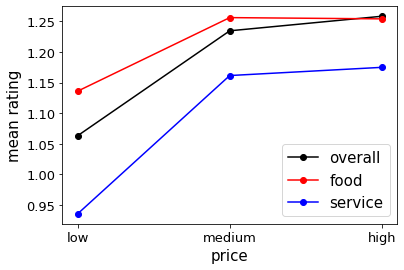

         overall      food   service
low     1.063059  1.135805  0.935632
medium  1.234342  1.255871  1.161361
high    1.258106  1.253816  1.174754


In [28]:
# mean rating as a function of price
plot_mean_rating(X[['price']])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


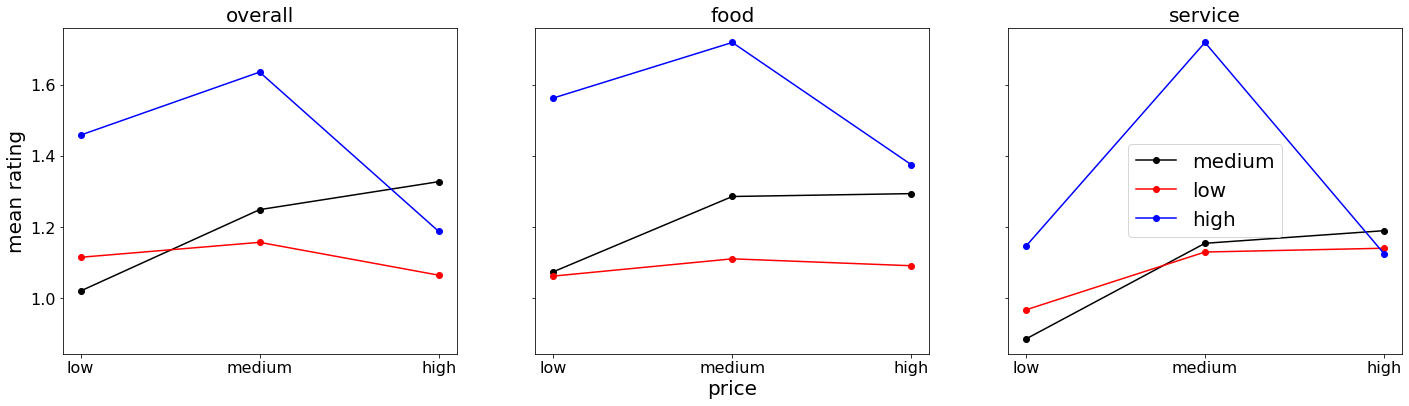

low budget:
         overall      food   service
low     1.114693  1.061776  0.966924
medium  1.156722  1.110335  1.129481
high    1.064394  1.090909  1.140152

medium budget:
         overall      food   service
low     1.019956  1.073880  0.884982
medium  1.248673  1.285623  1.154018
high    1.327263  1.293695  1.189459

high budget:
         overall     food   service
low     1.458333  1.56250  1.145833
medium  1.635417  1.71875  1.718750
high    1.187500  1.37500  1.125000


In [29]:
# mean rating as a function of price, split into three groups of consumers
# with low, medium, and high budget
y = plot_mean_rating_split(X[['price']],user_info.budget)

print('low budget:')
print(y['low'])
print('\nmedium budget:')
print(y['medium'])
print('\nhigh budget:')
print(y['high'])

**Observations: ** You get what you pay for? In general, restaurants with medium or high price have higher ratings (high ~ medium > low). However, the consumers with high budget actually prefer medium-price restaurants over high-price ones.

### Parking Lot

In [30]:
columns = ['parking_lot_none','parking_lot_public', 'parking_lot_valet parking','parking_lot_yes']
X[columns].sum()

parking_lot_none             65.0
parking_lot_public           16.0
parking_lot_valet parking     3.0
parking_lot_yes              46.0
dtype: float64

In [31]:
X[columns].sum().sum()

130.0

The sum is 130, which means each of these 130 restaurants actually only has one parking option (there were restaurants without ratings that have multiple parking options).

In [33]:
user_info.transport.value_counts()

no car       102
car owner     36
Name: transport, dtype: int64

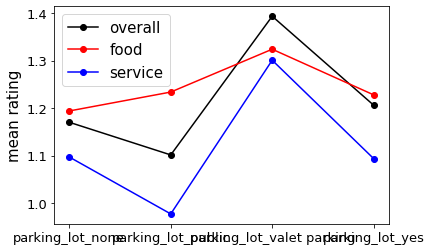

                            overall      food   service
parking_lot_none           1.170202  1.194014  1.097035
parking_lot_public         1.101438  1.233839  0.977173
parking_lot_valet parking  1.393519  1.324074  1.300926
parking_lot_yes            1.206176  1.227920  1.093676


In [34]:
# mean rating as a function of parking option
plot_mean_rating(X[columns])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


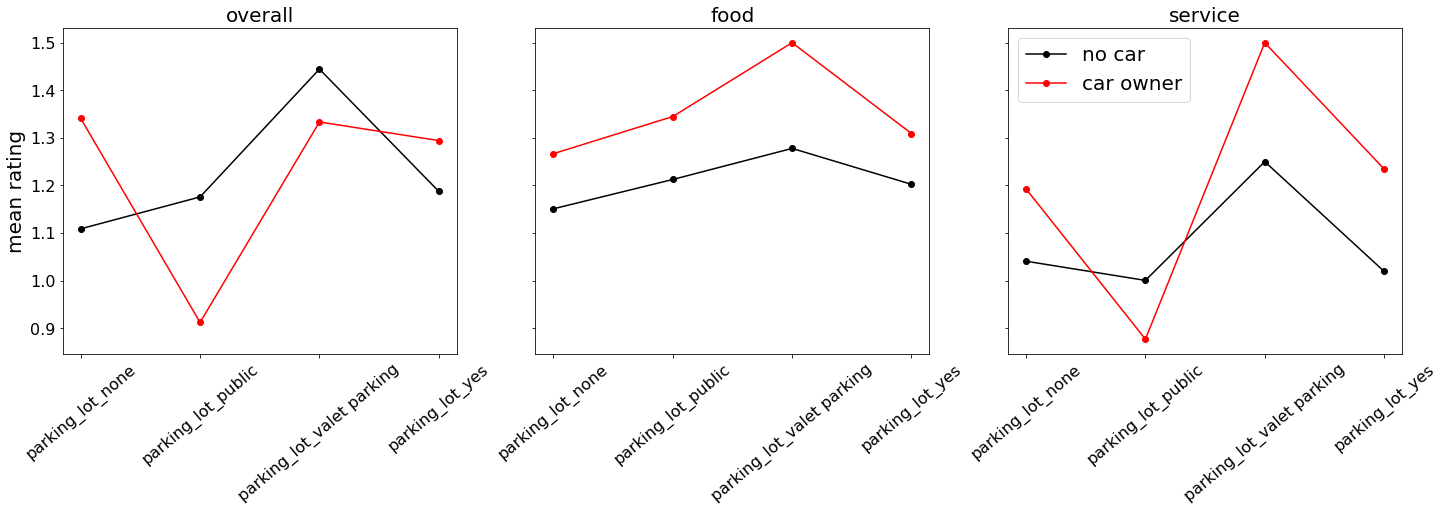

no car:
                            overall      food   service
parking_lot_none           1.108817  1.150848  1.040732
parking_lot_public         1.175832  1.212473  1.000369
parking_lot_valet parking  1.444444  1.277778  1.250000
parking_lot_yes            1.187421  1.202360  1.019356

car owner:
                            overall      food   service
parking_lot_none           1.340741  1.266715  1.192641
parking_lot_public         0.912063  1.344762  0.876825
parking_lot_valet parking  1.333333  1.500000  1.500000
parking_lot_yes            1.294246  1.309127  1.234524


In [35]:
# mean rating as a function of parking option, split into car owners and
# non car owners
y = plot_mean_rating_split(X[columns],user_info.transport,rotate=True)

print('no car:')
print(y['no car'])
print('\ncar owner:')
print(y['car owner'])

Observations: ** (1) Surprisingly, public parking is the least popular one, and it's worse than no parking. (2) Valet parking is the most popular one, although there are only three restaurants with this option. (3) Food rating changes the least among all three types of ratings, which makes sense since it shouldn't be affected by parking options at all. (4) The trend of ratings from car owners is actually not very different from non car owners.

Is it possible that parking options don't matter? Let's see if the trend we see above can be explained by **price, as we found previously that restaurants with medium or high price generally get higher ratings.

In [36]:
X.price[X['parking_lot_valet parking']==1].value_counts()

high    3
Name: price, dtype: int64

In [37]:
X.price[X['parking_lot_public']==1].value_counts()

medium    8
low       7
high      1
Name: price, dtype: int64

In [38]:
X.price[X['parking_lot_none']==1].value_counts()

low       31
medium    29
high       5
Name: price, dtype: int64

*Observations: * Apparently the restaurants with valet parking are the expensive/high-class ones, which is why they are highly rated. The compositions of the restaurants with public parking and no parking are similar; about half of either group are low-price restaurants. So the different ratings between these two groups given by car owners might be real. Maybe it's because public parking is expensive?

### Smoking Area

In [39]:
X.smoking_area.value_counts()

none             70
not permitted    25
section          24
permitted         9
only at bar       2
Name: smoking_area, dtype: int64

In [40]:
user_info.smoker.value_counts()

false    111
true      27
Name: smoker, dtype: int64

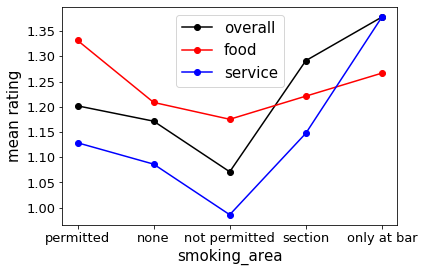

                overall      food   service
permitted      1.201852  1.331481  1.128704
none           1.171497  1.208648  1.086371
not permitted  1.071238  1.175244  0.986184
section        1.291368  1.221073  1.147479
only at bar    1.377778  1.266667  1.377778


In [41]:
# mean rating as a function of smoking area
plot_mean_rating(X[['smoking_area']])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


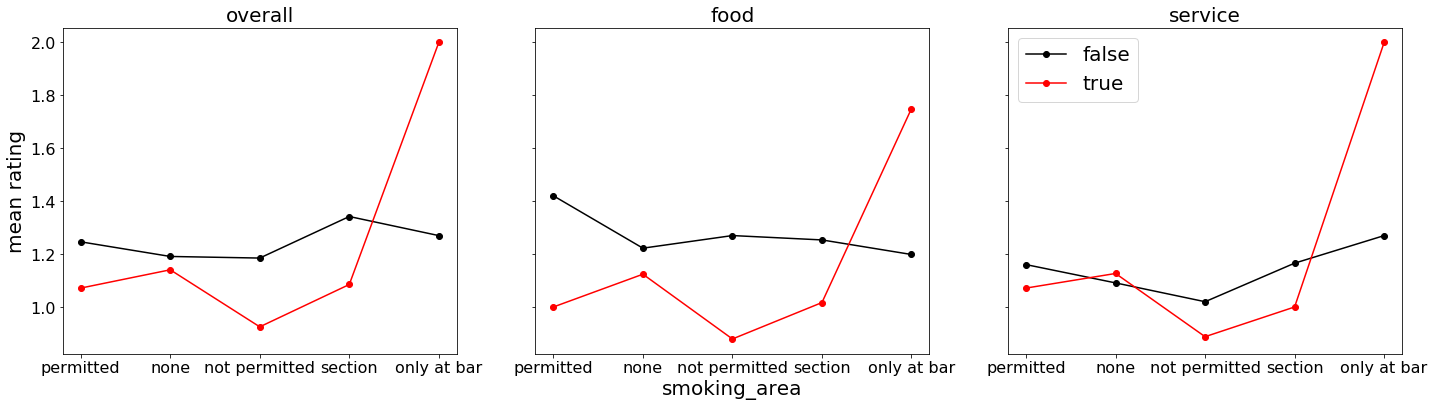

false:
                overall      food   service
permitted      1.246296  1.420370  1.160185
none           1.190995  1.222333  1.090993
not permitted  1.184933  1.269985  1.019883
section        1.342021  1.253493  1.165625
only at bar    1.269841  1.198413  1.269841

true:
                overall      food   service
permitted      1.071429  1.000000  1.071429
none           1.140556  1.123889  1.126667
not permitted  0.924943  0.879025  0.887642
section        1.085000  1.016667  1.000000
only at bar    2.000000  1.750000  2.000000


In [42]:
# mean rating as a function of smoking area, split into smokers and
# non smokers
y = plot_mean_rating_split(X[['smoking_area']],user_info.smoker)

print('false:')
print(y['false'])
print('\ntrue:')
print(y['true'])

**Observations: ** (1) Non smokers do not care much about smoking area. (2) For smokers, **only at bar** is very popular, while **not permitted** leads to very low ratings. (3) Surprisingly, **none** and **not permitted** have very different mean ratings. Originally I thought these two mean the same thing. It's probably because smokers can still find a place to smoke at those restaurants without a smoking area but are completely not allowed to do so at those **not permitted** ones.

### Alcohol

In [43]:
X.alcohol.value_counts()

No_Alcohol_Served    87
Wine-Beer            34
Full_Bar              9
Name: alcohol, dtype: int64

In [44]:
user_info.drink_level.value_counts()

abstemious        51
casual drinker    47
social drinker    40
Name: drink_level, dtype: int64

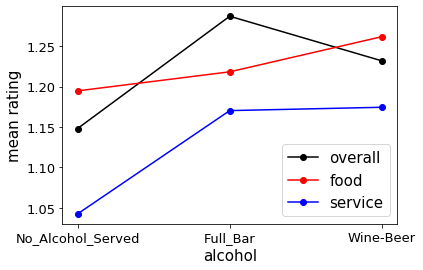

                    overall      food   service
No_Alcohol_Served  1.148075  1.194730  1.042417
Full_Bar           1.287124  1.218315  1.170311
Wine-Beer          1.231887  1.261840  1.174437


In [45]:
# mean rating as a function of alcohol
plot_mean_rating(X[['alcohol']])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


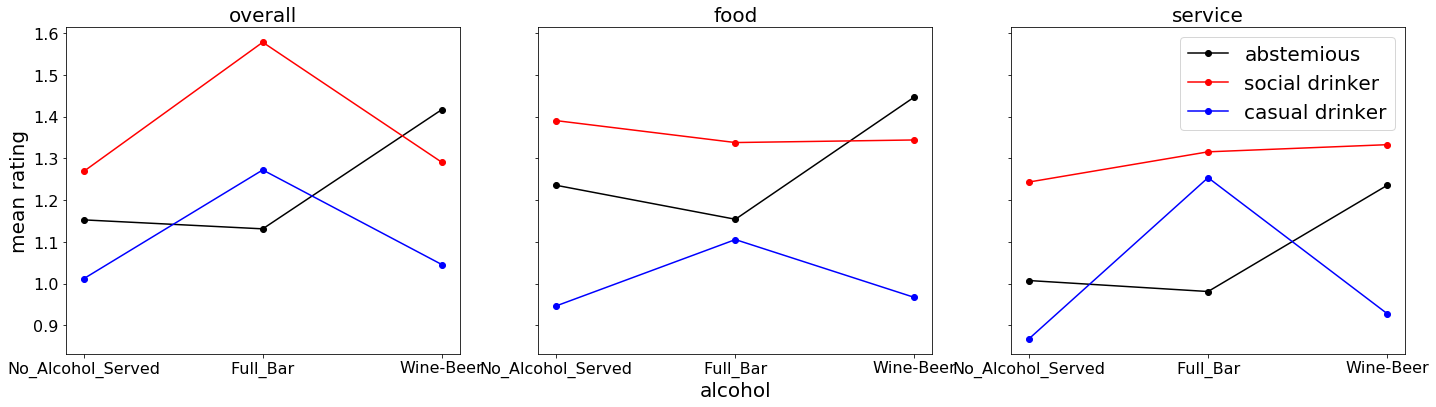

abstemious:
                    overall      food   service
No_Alcohol_Served  1.152724  1.235381  1.007545
Full_Bar           1.131250  1.154167  0.981250
Wine-Beer          1.416558  1.446861  1.235245

casual drinker:
                    overall      food   service
No_Alcohol_Served  1.011874  0.946976  0.868174
Full_Bar           1.272222  1.105556  1.253704
Wine-Beer          1.045852  0.967113  0.928460

social drinker:
                    overall      food   service
No_Alcohol_Served  1.268686  1.390192  1.243299
Full_Bar           1.577778  1.337778  1.315556
Wine-Beer          1.290646  1.343963  1.332653


In [46]:
# mean rating as a function of smoking alcohol, split into abstemious, 
# casual and social drinkers
y = plot_mean_rating_split(X[['alcohol']],user_info.drink_level)

print('abstemious:')
print(y['abstemious'])
print('\ncasual drinker:')
print(y['casual drinker'])
print('\nsocial drinker:')
print(y['social drinker'])

**Observations: ** Abstemious drinkers prefer **Wine-Beer**; casual drinkers prefer **Full_Bar**; but it's not so clear for social drinkers.
<br><br>
Let's check again if the trend we see above can be explained by **price**.

In [47]:
X.price[X.alcohol == 'No_Alcohol_Served'].value_counts()

medium    41
low       39
high       7
Name: price, dtype: int64

In [48]:
X.price[X.alcohol == 'Wine-Beer'].value_counts()

medium    15
high      14
low        5
Name: price, dtype: int64

In [49]:
X.price[X.alcohol == 'Full_Bar'].value_counts()

high      4
medium    4
low       1
Name: price, dtype: int64

**Observations: ** On average, the order of price is **Full_Bar** > **Wine-Beer** > **No_Alcohol_Served**, which does not explain the ratings drinkers of abstemious and social drinkers.

### Other Services

In [50]:
X.other_services.value_counts()

none        119
variety       7
Internet      4
Name: other_services, dtype: int64

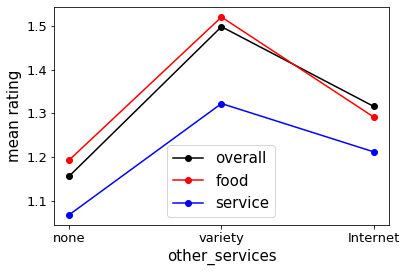

           overall      food   service
none      1.156273  1.193252  1.067643
variety   1.498639  1.520748  1.322449
Internet  1.315972  1.291667  1.211806


In [51]:
# mean rating as a function of other_services
plot_mean_rating(X[['other_services']])

**Observations: ** The order of rating is **Variety** > **Internet** > **None**, consistent with the amount of other service provided.
<br><br>
Again, is it just caused by **price**?

In [53]:
X.price[X.other_services == 'variety'].value_counts()

medium    4
low       2
high      1
Name: price, dtype: int64

In [54]:
X.price[X.other_services == 'Internet'].value_counts()

medium    3
high      1
Name: price, dtype: int64

In [55]:
X.price[X.other_services == 'none'].value_counts()

medium    53
low       43
high      23
Name: price, dtype: int64

**Observations: ** Restaurants with **Internet** actually have a higher mean price than those with **Variety**. So the ratings are indeed affected by the amount of other service provided.

### Dress Code

In [56]:
X.dress_code.value_counts()

informal    118
casual       10
formal        2
Name: dress_code, dtype: int64

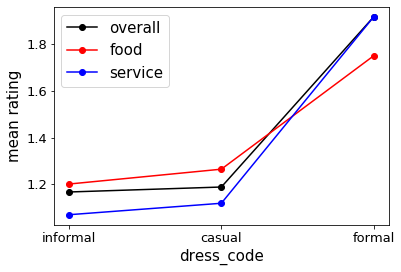

           overall      food   service
informal  1.166441  1.200562  1.068978
casual    1.187739  1.264256  1.118116
formal    1.916667  1.750000  1.916667


In [57]:
# mean rating as a function of dress code
plot_mean_rating(X[['dress_code']])

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


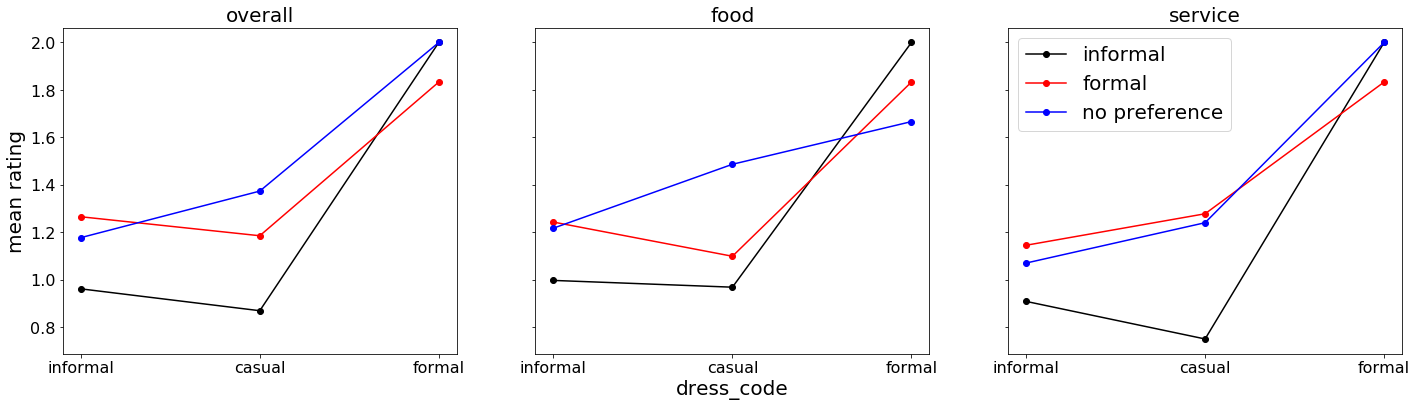

no preference:
           overall      food   service
informal  1.177720  1.217728  1.070757
casual    1.373889  1.486825  1.240714
formal    2.000000  1.666667  2.000000

informal:
           overall      food   service
informal  0.962149  0.997638  0.909323
casual    0.870000  0.969134  0.750952
formal    2.000000  2.000000  2.000000

formal:
           overall      food   service
informal  1.265841  1.243413  1.145705
casual    1.185802  1.099383  1.278395
formal    1.833333  1.833333  1.833333


In [58]:
# mean rating as a function of smoking alcohol, split into different 
# groups of consumers with different dress preferences
y = plot_mean_rating_split(X[['dress_code']],user_info.dress_preference)

print('no preference:')
print(y['no preference'])
print('\ninformal:')
print(y['informal'])
print('\nformal:')
print(y['formal'])

**Observations: ** Restaurants that require the customers to dress formally have the highest ratings. This is not a surprise because they should be expensive/high-class restaurants. Again, we can check the corresponding price in the following.

In [60]:
X.price[X.dress_code == 'formal'].value_counts()

high      1
medium    1
Name: price, dtype: int64

In [61]:
X.price[X.dress_code == 'informal'].value_counts()

medium    57
low       40
high      21
Name: price, dtype: int64

In [62]:
X.price[X.dress_code == 'casual'].value_counts()

low       5
high      3
medium    2
Name: price, dtype: int64

### Accessibility

In [63]:
X.accessibility.value_counts()

no_accessibility    76
completely          45
partially            9
Name: accessibility, dtype: int64

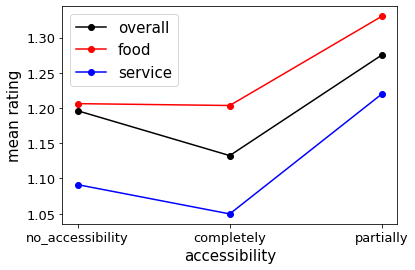

                   overall      food   service
no_accessibility  1.196189  1.206242  1.091278
completely        1.132494  1.203597  1.049709
partially         1.275356  1.330294  1.219991


In [64]:
# mean rating as a function of dress accessibility
plot_mean_rating(X[['accessibility']])

**Observations: ** If accessibility could affect the rating, we would expect **completely > partially > no_accessibility**. However, this is not we see here. In the following, we can see that the trend is simply due to price again.

In [66]:
X.price[X.accessibility == 'partially'].value_counts()

medium    8
low       1
Name: price, dtype: int64

In [67]:
X.price[X.accessibility == 'no_accessibility'].value_counts()

medium    39
high      23
low       14
Name: price, dtype: int64

In [68]:
X.price[X.accessibility == 'completely'].value_counts()

low       30
medium    13
high       2
Name: price, dtype: int64

### Area

In [69]:
X.area.value_counts()

closed    115
open       15
Name: area, dtype: int64

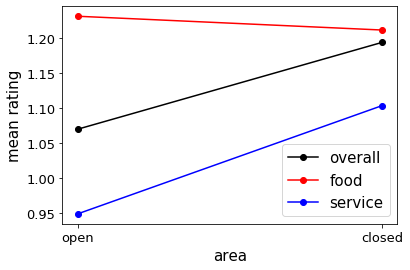

         overall      food   service
open    1.069992  1.231315  0.949101
closed  1.193921  1.211645  1.103630


In [70]:
# mean rating as a function of area
plot_mean_rating(X[['area']])

**Observations: ** Food rating does not depend on **area**, but from overall and service ratings, we can tell that consumers still prefer closed area over open area.

### Cuisine

In [71]:
# the number of restaurants for each cuisine type 
X.iloc[:,:23].sum()

Rcuisine_American             5.0
Rcuisine_Armenian             1.0
Rcuisine_Bakery               1.0
Rcuisine_Bar                 13.0
Rcuisine_Bar_Pub_Brewery      6.0
Rcuisine_Breakfast-Brunch     1.0
Rcuisine_Burgers              5.0
Rcuisine_Cafe-Coffee_Shop     1.0
Rcuisine_Cafeteria            9.0
Rcuisine_Chinese              3.0
Rcuisine_Contemporary         2.0
Rcuisine_Family               2.0
Rcuisine_Fast_Food            8.0
Rcuisine_Game                 1.0
Rcuisine_International        4.0
Rcuisine_Italian              4.0
Rcuisine_Japanese             5.0
Rcuisine_Mediterranean        1.0
Rcuisine_Mexican             28.0
Rcuisine_Pizzeria             5.0
Rcuisine_Regional             1.0
Rcuisine_Seafood              5.0
Rcuisine_Vietnamese           1.0
dtype: float64

In [72]:
# Besides Mexican, Cafeteria and Fast_Food, group the other types into 
# the following 5 types

X['Rcuisine_Bar_Pub'] = np.zeros(X.shape[0])
index = ((X.Rcuisine_Bar == 1) | (X.Rcuisine_Bar_Pub_Brewery == 1))
X.loc[index,'Rcuisine_Bar_Pub'] = 1

X['Rcuisine_Asian'] = np.zeros(X.shape[0])
index = ((X.Rcuisine_Chinese == 1) | (X.Rcuisine_Japanese == 1) | (X.Rcuisine_Vietnamese == 1))
X.loc[index,'Rcuisine_Asian'] = 1

X['Rcuisine_Western'] = np.zeros(X.shape[0])
index = ((X.Rcuisine_Armenian == 1) | (X.Rcuisine_Italian == 1) | (X.Rcuisine_Mediterranean == 1) 
         | (X.Rcuisine_Pizzeria == 1) | (X.Rcuisine_Seafood == 1))
X.loc[index,'Rcuisine_Western'] = 1

X['Rcuisine_American_Burgers'] = np.zeros(X.shape[0])
index = ((X.Rcuisine_American == 1) | (X.Rcuisine_Burgers == 1))
X.loc[index,'Rcuisine_American_Burgers'] = 1

X['Rcuisine_Others'] = np.zeros(X.shape[0])
index = (((X.Rcuisine_Bakery == 1) | (X["Rcuisine_Breakfast-Brunch"] == 1) | (X["Rcuisine_Cafe-Coffee_Shop"] == 1) 
        | (X.Rcuisine_Contemporary == 1) | (X.Rcuisine_Family == 1) | (X.Rcuisine_Game == 1) 
        | (X.Rcuisine_International == 1) | (X.Rcuisine_Regional == 1)))
X.loc[index,'Rcuisine_Others'] = 1

In [73]:
print("Number of restaurants for each type")
print("Mexican: {}".format(int(X.Rcuisine_Mexican.sum())))
print("American/Burgers: {}".format(int(X.Rcuisine_American_Burgers.sum())))
print("Asian: {}".format(int(X.Rcuisine_Asian.sum()))) 
print("Bar/Pub: {}".format(int(X.Rcuisine_Bar_Pub.sum()))) 
print("Cafeteria: {}".format(int(X.Rcuisine_Cafeteria.sum()))) 
print("Fast Food: {}".format(int(X.Rcuisine_Fast_Food.sum()))) 
print("Others: {}".format(int(X.Rcuisine_Others.sum())))
print("Western: {}".format(int(X.Rcuisine_Western.sum())))

Number of restaurants for each type
Mexican: 28
American/Burgers: 10
Asian: 9
Bar/Pub: 14
Cafeteria: 9
Fast Food: 8
Others: 13
Western: 16


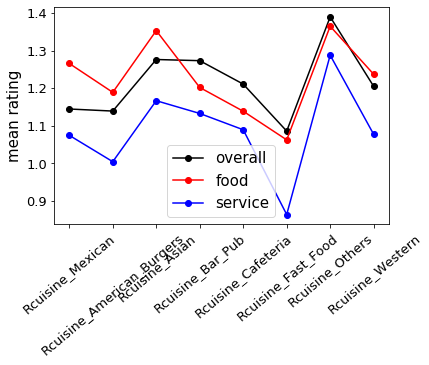

                            overall      food   service
Rcuisine_Mexican           1.144555  1.265529  1.074582
Rcuisine_American_Burgers  1.139048  1.188810  1.004524
Rcuisine_Asian             1.276089  1.352887  1.166612
Rcuisine_Bar_Pub           1.273005  1.201773  1.132715
Rcuisine_Cafeteria         1.210745  1.138655  1.089418
Rcuisine_Fast_Food         1.085827  1.062563  0.864078
Rcuisine_Others            1.389438  1.364469  1.287546
Rcuisine_Western           1.204843  1.236983  1.077241


In [74]:
columns = ['Rcuisine_Mexican','Rcuisine_American_Burgers', 'Rcuisine_Asian','Rcuisine_Bar_Pub', 'Rcuisine_Cafeteria',
           'Rcuisine_Fast_Food','Rcuisine_Others','Rcuisine_Western']
plot_mean_rating(X[columns],rotate=True)

Let's also check the correlation coefficients between these cuisine types and the ratings

In [75]:
X_cuisine = X[['Rcuisine_Mexican','Rcuisine_American_Burgers','Rcuisine_Asian','Rcuisine_Bar_Pub','Rcuisine_Cafeteria',
           'Rcuisine_Fast_Food','Rcuisine_Western','Rcuisine_Others']]

X_cuisine['Y_food'] = Y_food_mean
X_cuisine['Y_overall'] = Y_overall_mean
X_cuisine['Y_service'] = Y_service_mean

In [76]:
print(X_cuisine.corr()['Y_overall'][:-3])
print('\n')
print(X_cuisine.corr()['Y_food'][:-3])
print('\n')
print(X_cuisine.corr()['Y_service'][:-3])
print('\n')

Rcuisine_Mexican            -0.052793
Rcuisine_American_Burgers   -0.033656
Rcuisine_Asian               0.075600
Rcuisine_Bar_Pub             0.093221
Rcuisine_Cafeteria           0.024391
Rcuisine_Fast_Food          -0.069017
Rcuisine_Western             0.027151
Rcuisine_Others              0.200969
Name: Y_overall, dtype: float64


Rcuisine_Mexican             0.080017
Rcuisine_American_Burgers   -0.021444
Rcuisine_Asian               0.112147
Rcuisine_Bar_Pub            -0.012480
Rcuisine_Cafeteria          -0.060732
Rcuisine_Fast_Food          -0.114679
Rcuisine_Western             0.025572
Rcuisine_Others              0.148492
Name: Y_food, dtype: float64


Rcuisine_Mexican            -0.017664
Rcuisine_American_Burgers   -0.070513
Rcuisine_Asian               0.066238
Rcuisine_Bar_Pub             0.048983
Rcuisine_Cafeteria           0.002966
Rcuisine_Fast_Food          -0.170635
Rcuisine_Western            -0.009636
Rcuisine_Others              0.202107
Name: Y_service, dtype:

**Observations: ** Although the correlations are slightly different between different ratings, **Rcuisine_Others** generally gets higher ratings and **Rcuisine_Fast_Food** generally gets lower ratings. Asian restaurants perform really well at food rating. Interestingly, Mexican restaurants have above than average food rating but just roughly average overall and service ratings.

## Conclusion

So what features affect the ratings? 
- **Price** is definitely one. In general, medium and high-price restaurants have better rating. However, it may be better to transform the original categories (low, medium, high) using dummy variables (one-hot encoding) instead of directly mapping them to numbers (such as 1,2,3). This is because we saw that people with different budget actually react differently on the price change.
<br><br>
- **Parking Lot** can affect the ratings too, but not the food rating. Also, it only matters to car owners. We saw that restaurants with public parking have significantly lower overall and service ratings.
<br><br>
- **Smoking Area** is only important for smokers. Especially, restaurants that do not allow smoking are low rated, and restaurants with their smoking area located at bar are highly rated.
<br><br>
- **Alcohol** is also relevant but different types of drinkers react differently on the change of alcohol service (No_Alcohol_Served, Wine-Beer, Full_Bar). Similar to **Price**, it may be better to transform the original three categories using dummy variables.
<br><br>
- **Other Services** has influence on the ratings. We saw that restaurants with a variety of other service perform better than those with only Internet. And those with Internet are better than those without other services.
<br><br>
- The effect of **Dress Code** on the ratings is probably due to **Price**. There are only two restaurants that require the customers to dress formally, and their ratings are close to 2.
<br><br>
- **Accessibility** does not affect the ratings. For **Area**, people prefer closed space over open space. For **Cuisine**, what restaurant/food types are relevant depend on which rating we are trying to predict. But in general, some types have significant influence. For example, fast food restaurants generally have low ratings. 